# Batch growth on a mix of polysaccharides

In [1]:
import pandas as pd
import numpy as np
import copy
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec

import cobra
import reframed
import molmass
import sys
sys.path.append("../functions/")

%load_ext autoreload
%autoreload 2


import dfba_cobra_multiple_polysaccharides


In [2]:
%run ../scripts/polysaccharide_monosaccharide_composition.py

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2025-03-14


### Wheat straw: A source of arabinoxylan

In [3]:
media = pd.read_csv('../input/media_db.tsv',sep='\t')
media = media.groupby('medium').agg({'compound': set})['compound'].to_dict()

model = dfba_cobra_multiple_polysaccharides.read_model(media)

**Determine weight fraction of each monosaccharide in each polysaccharide**

Assumption: A polysaccharides is degraded so that we have equal mol of carbon from each oligosaccharide. 

In [4]:
polysac_weight_frac = pd.read_csv("../input/polysaccharide_monosaccharide_weight_fractions.tsv",sep="\t",index_col=0)

# Add requirement for fraction of cellulose
polysac_weight_frac = polysac_weight_frac.T

polysac_weight_frac["Cellulose content"] = [0,0,1,0]
polysac_weight_frac["Xyloglucan content"] = [0,1,0,0]
polysac_weight_frac = polysac_weight_frac.T
polysac_weight_frac

,EX_arabinoxylan_e,EX_xyloglucan_e,EX_cellulose_e,EX_xylan_e
Glucose,0.000000,0.571704,1.0,0.000000
Xylose,0.696667,0.327903,0.0,0.877324
Galactose,0.000000,0.100392,0.0,0.000000
Arabinose,0.303333,0.000000,0.0,0.000000
Glucuronic acid,0.000000,0.000000,0.0,0.122676
Cellulose content,0.000000,0.000000,1.0,0.000000
Xyloglucan content,0.000000,1.000000,0.0,0.000000


**Determine mol of each polysaccharide needed to achieve the polysaccharide concentration**

In [5]:
desired_ratio_mol_dict = {"Glucose":45,
                    "Xylose":43.6,
                    "Galactose": 1.34,
                    "Arabinose":6.0,
                    "Glucuronic acid":3.9}

desired_ratio_cell = 27.30/(41.7+27.30)


In [6]:
desired_ratio_g =np.array([mol_frac*molmass.Formula(model.metabolites.get_by_id(dfba_cobra_multiple_polysaccharides.name2id[met_name]).notes["FORMULA"]).mass   
    for met_name,mol_frac in desired_ratio_mol_dict.items()])

# Desired weight ratio between the different monosaccharides
desired_ratio_ww = desired_ratio_g/sum(desired_ratio_g)
desired_ratio = desired_ratio_ww

# Desired ratio of different polysaccharides
desired_ratio = np.append(desired_ratio,desired_ratio_cell) # Cellulose
desired_ratio = np.append(desired_ratio,0) # Xyloglucan
# Least squares to get an approximate composition
polysac = np.dot(np.linalg.pinv(polysac_weight_frac.to_numpy()),desired_ratio.transpose())

polysac = polysac/sum(polysac)

In [7]:
pd.DataFrame({"Fitted weight ratio of polysaccharides":dict(zip(polysac_weight_frac.columns,polysac))})

,Fitted weight ratio of polysaccharides
EX_arabinoxylan_e,0.182430
EX_cellulose_e,0.464627
EX_xylan_e,0.327469
EX_xyloglucan_e,0.025474


**The monosaccharide composition in our model is relatively close to the actual sugar composition**

In [8]:
pd.DataFrame({"Desired weight ratio":dict(zip(polysac_weight_frac.index,desired_ratio)),
"Fitted weight ratio":dict(zip(polysac_weight_frac.index,np.dot(polysac_weight_frac.to_numpy(),polysac)))})

,Desired weight ratio,Fitted weight ratio
Glucose,0.489907,0.479190
Xylose,0.395554,0.422743
Galactose,0.014588,0.002557
Arabinose,0.054434,0.055337
Glucuronic acid,0.045517,0.040172
Cellulose content,0.395652,0.464627
Xyloglucan content,0.000000,0.025474


### Simulation

In [9]:
# The oligosaccharide composition of each polysaccharide

glc_eq_poly_dict =OrderedDict({"EX_arabinoxylan_e":{
"EX_AX_e": 15/6,
"EX_AXX_e": 20/6,
"EX_A23XX_e": 25/6,
"EX_XAXX_e": 25/6,
"EX_XA23XX_e": 30/6},
                              
"EX_xyloglucan_e":{                              
"EX_QLQG_e": 45/6,
"EX_QQLG_e":45/6,
"EX_QLLG_e":51/6,
"EX_QQQG_e":39/6,
"EX_GQQG_e":34/6},

"EX_cellulose_e":{"EX_cellb_e": 2,
"EX_cell3_e": 3,
"EX_cell4_e": 4,
"EX_cell5_e":5},
                               
"EX_xylan_e":{
"EX_xylb_e":10/6,
"EX_xyl3_e":15/6,
"EX_xylan4_e":26/6,
"EX_xylan8_e":52/6}

})

C_dict =OrderedDict()
C_dict["Growth"]=0.1
for rxns in glc_eq_poly_dict.values(): 
    for rxn in rxns: C_dict[rxn]=0
C_dict["EX_ac_e"]=0
C_dict["EX_co2_e"]=0

#polysac #EX_arabinoxylan_e	EX_xyloglucan_e	EX_cellulose_e	EX_xylan_e
C_dict["EX_arabinoxylan_e"]= polysac[0]*100
C_dict["EX_xyloglucan_e"]= polysac[1]*100
C_dict["EX_cellulose_e"]= polysac[2]*100
C_dict["EX_xylan_e"]= polysac[3]*100

rxns = list(C_dict.keys())
y0 = np.array(list(C_dict.values()))

objective_dir = ["max", "max","max","max","max","max","max","max","max","max","max","max","max","max","max","max","max","max","max","max","max"]
best_r2 = {}

In [10]:
%%time
C_results_tot = dfba_cobra_multiple_polysaccharides.multiple_polysaccharide_simulation([10/4,5,3/4,5],
                                                    model,
                                                    media,
                                                    rxns,
                                                    y0,
                                                    objective_dir,
                                                    glc_eq_poly_dict,
                                                    t_end=100)

Lack of xyloglucan: -0.000578661049618916
Lack of xyloglucan: -0.000578661049618916
Lack of xyloglucan: -2.1232908826556915e-05
Lack of xyloglucan: -3.467852394134496e-11
Lack of xyloglucan: -4.5102810375396984e-17
CPU times: user 37.3 s, sys: 139 ms, total: 37.4 s
Wall time: 37.5 s


In [11]:
color_dict = {'EX_arabinoxylan_e':["lightblue","tab:blue","blue","darkblue","#02022e"],
              'EX_xyloglucan_e':["pink","tab:red","red","darkred","brown"],
              'EX_cellulose_e':["lightgreen","#60bf68","green","#223624"],
              'EX_xylan_e':["yellow","#fcdb03","#fcba03","#e67802"]}

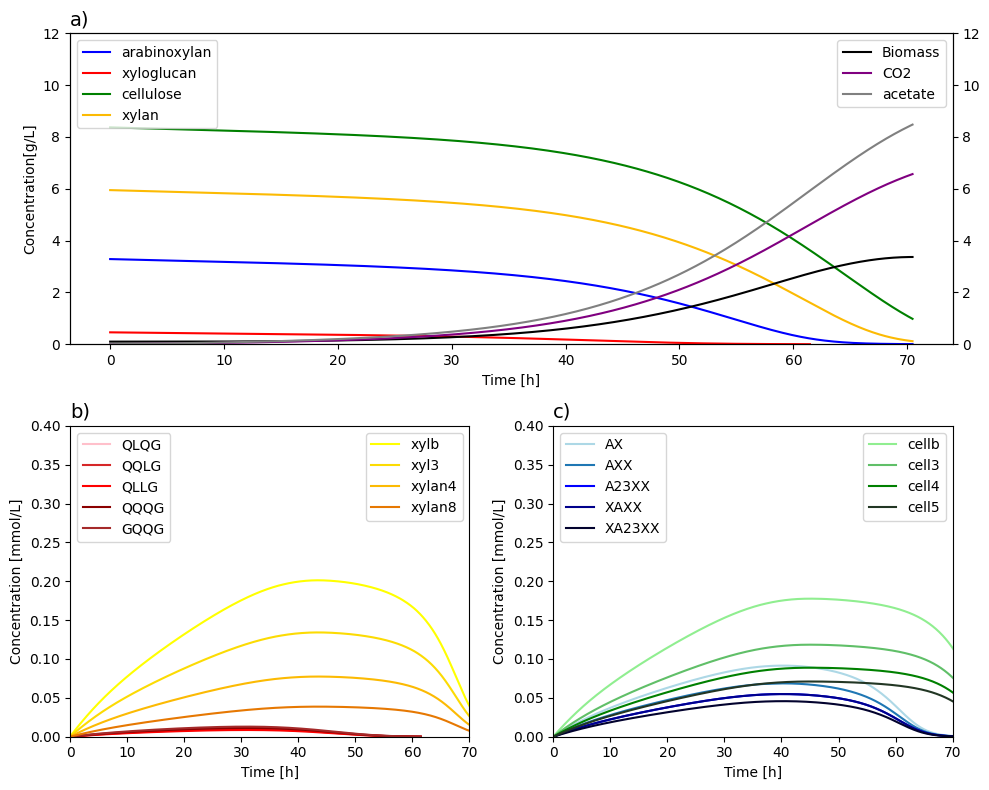

In [14]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(8,4,figure=fig)
ax1 = fig.add_subplot(gs[ -4:,0:2])
ax2 = fig.add_subplot(gs[-4:,2: ])
ax3 = fig.add_subplot(gs[:-4,0:])

artists = {}
for polysac_id,color_list in color_dict.items():
    if polysac_id in ["EX_xylan_e","EX_xyloglucan_e"]:
        ax = ax1
    elif polysac_id in ["EX_cellulose_e","EX_arabinoxylan_e"]:
        ax = ax2
    
    artists[polysac_id] = []
    for i,oligosacc_id in enumerate(glc_eq_poly_dict[polysac_id].keys()):
        #ax.plot(C_results_tot[oligosacc_id]["t"],C_results_tot[oligosacc_id]["C"],color=color_list[i],label=f"{polysac_id[3:-2]}: {oligosacc_id[3:-2]}")

        artist = ax.plot(C_results_tot[oligosacc_id]["t"],np.array(C_results_tot[oligosacc_id]["C"]),color=color_list[i],label=f"{oligosacc_id[3:-2]}")
        artists[polysac_id].extend(artist)
    polysac_g = monosac_comp_g[monosac_comp_g.index.isin(oligosac_fracs[polysac_id].keys())].sum().sum()
    ax3.plot(C_results_tot[polysac_id]["t"],np.array(C_results_tot[polysac_id]["C"])*polysac_g/1000,color=color_list[2],label=polysac_id[3:-2])

ax3.set_xlabel("Time [h]")
ax3.set_ylabel("Concentration[g/L]")
ax3.set_ylim([0,12])
ax3.legend(loc="upper left")
ax3.set_title("a)",loc="left",fontsize=14)

ax3_twin = ax3.twinx()
ax3_twin.plot(C_results_tot["Growth"]["t"],C_results_tot["Growth"]["C"],color="black",label="Biomass")
#ax3_twin.set_ylabel("Conc. [g/L]")

ax3_twin.plot(C_results_tot["EX_co2_e"]["t"],np.array(C_results_tot["EX_co2_e"]["C"])*molmass.Formula(model.metabolites.co2_e.formula).mass/1000,label="CO2",color="purple")
ax3_twin.plot(C_results_tot["EX_ac_e"]["t"],np.array(C_results_tot["EX_ac_e"]["C"])*molmass.Formula(model.metabolites.ac_e.formula).mass/1000,label="acetate",color="grey")


ax3_twin.set_ylim([0,12])
ax3_twin.legend(loc="upper right")

    
ax1.set_ylim([0,0.4])
ax1.set_xlim([0,70])
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Concentration [mmol/L]")
xylan_legend = ax1.legend(handles=artists["EX_xylan_e"],loc='upper right')
xylogluc_legend = ax1.legend(handles=artists["EX_xyloglucan_e"],loc='upper left')
ax1.add_artist(xylan_legend)
ax1.set_title("b)",loc="left",fontsize=14)

ax2.set_ylim([0,0.4])
ax2.set_xlim([0,70])
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Concentration [mmol/L]")
cellulose_legend = ax2.legend(handles=artists["EX_cellulose_e"],loc='upper right')
xylogluc_legend = ax2.legend(handles=artists["EX_arabinoxylan_e"],loc='upper left')
ax2.add_artist(cellulose_legend)

ax2.set_title("c)",loc="left",fontsize=14)

plt.tight_layout()
plt.savefig("../figures/wheat_straw_simulation.png")